In [1]:
import os
import uproot
import numpy as np

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for branch in branches:
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

branches_list = [
    't5_innerRadius',
    't5_bridgeRadius',
    't5_outerRadius',
    't5_pt',
    't5_eta',
    't5_phi',
    't5_isFake',
    't5_t3_idx0',
    't5_t3_idx1',
    't5_pMatched',
    't5_sim_vxy',
    't5_sim_vz'
]

# Hit-dependent branches
suffixes = ['r', 'z', 'eta', 'phi', 'layer']
branches_list += [f't5_t3_{i}_{suffix}' for i in [0, 2, 4] for suffix in suffixes]

file_path = "1000_no_dnn_no_dbeta2_after_bug_new.root"
branches = load_root_file(file_path, branches_list)

In [2]:
z_max = np.max([np.max(event) for event in branches[f't5_t3_4_z']])
r_max = np.max([np.max(event) for event in branches[f't5_t3_4_r']])
eta_max = 2.5
phi_max = np.pi

print(f'Z max: {z_max}, R max: {r_max}, Eta max: {eta_max}')

def delta_phi(phi1, phi2):
    delta = phi1 - phi2
    # Adjust delta to be within the range [-pi, pi]
    if delta > np.pi:
        delta -= 2 * np.pi
    elif delta < -np.pi:
        delta += 2 * np.pi
    return delta

Z max: 267.2349853515625, R max: 110.10993957519531, Eta max: 2.5


In [3]:
features_list = []
eta_list = [] # Used for DNN cut values

for event in range(branches['event']):
    # Determine the number of elements in this event
    num_elements = len(branches['t5_t3_idx0'][event])

    for i in range(num_elements):
        features_iter = []
        eta_iter = []
        
        idx0 = branches['t5_t3_idx0'][event][i]
        idx1 = branches['t5_t3_idx1'][event][i]

        eta1 = np.abs(branches['t5_t3_0_eta'][event][idx0])
        eta2 = np.abs(branches['t5_t3_2_eta'][event][idx0])
        eta3 = np.abs(branches['t5_t3_4_eta'][event][idx0])
        eta4 = np.abs(branches['t5_t3_2_eta'][event][idx1])
        eta5 = np.abs(branches['t5_t3_4_eta'][event][idx1])

        phi1 = (branches['t5_t3_0_phi'][event][idx0])
        phi2 = (branches['t5_t3_2_phi'][event][idx0])
        phi3 = (branches['t5_t3_4_phi'][event][idx0])
        phi4 = (branches['t5_t3_2_phi'][event][idx1])
        phi5 = (branches['t5_t3_4_phi'][event][idx1])

        z1 = np.abs(branches['t5_t3_0_z'][event][idx0])
        z2 = np.abs(branches['t5_t3_2_z'][event][idx0])
        z3 = np.abs(branches['t5_t3_4_z'][event][idx0])
        z4 = np.abs(branches['t5_t3_2_z'][event][idx1])
        z5 = np.abs(branches['t5_t3_4_z'][event][idx1])

        r1 = branches['t5_t3_0_r'][event][idx0]
        r2 = branches['t5_t3_2_r'][event][idx0]
        r3 = branches['t5_t3_4_r'][event][idx0]
        r4 = branches['t5_t3_2_r'][event][idx1]
        r5 = branches['t5_t3_4_r'][event][idx1]

        innerRad = branches['t5_innerRadius'][event][i]
        bridgeRad = branches['t5_bridgeRadius'][event][i]
        outerRad = branches['t5_outerRadius'][event][i]

        # Construct the input feature vector using pairwise differences
        features_iter = [
            eta1 / eta_max,                      # First hit eta, normalized
            np.abs(phi1) / phi_max,              # First hit phi, normalized
            z1 / z_max,                          # First hit z, normalized
            r1 / r_max,                          # First hit r, normalized

            eta2 - eta1,                         # Difference in eta between hit 2 and 1
            delta_phi(phi2, phi1) / phi_max,     # Difference in phi between hit 2 and 1
            (z2 - z1) / z_max,                   # Difference in z between hit 2 and 1, normalized
            (r2 - r1) / r_max,                   # Difference in r between hit 2 and 1, normalized

            eta3 - eta2,                         # Difference in eta between hit 3 and 2
            delta_phi(phi3, phi2) / phi_max,     # Difference in phi between hit 3 and 2
            (z3 - z2) / z_max,                   # Difference in z between hit 3 and 2, normalized
            (r3 - r2) / r_max,                   # Difference in r between hit 3 and 2, normalized

            eta4 - eta3,                         # Difference in eta between hit 4 and 3
            delta_phi(phi4, phi3) / phi_max,     # Difference in phi between hit 4 and 3
            (z4 - z3) / z_max,                   # Difference in z between hit 4 and 3, normalized
            (r4 - r3) / r_max,                   # Difference in r between hit 4 and 3, normalized

            eta5 - eta4,                         # Difference in eta between hit 5 and 4
            delta_phi(phi5, phi4) / phi_max,     # Difference in phi between hit 5 and 4
            (z5 - z4) / z_max,                   # Difference in z between hit 5 and 4, normalized
            (r5 - r4) / r_max,                   # Difference in r between hit 5 and 4, normalized

            np.log10(innerRad),
            np.log10(bridgeRad),
            np.log10(outerRad)
        ]

        # Use the abs eta value of first hit to select cut thresholds
        eta_iter.extend([np.abs(branches['t5_t3_0_eta'][event][idx0])])
        
        # Append the feature vector to the list
        features_list.append(features_iter)
        eta_list.append(eta_iter)

# Convert the list of features to a NumPy array
features = np.array(features_list).T
eta_list = np.array(eta_list).T

In [4]:
import numpy as np

def downsample_tracks(features, eta_list, p_matched, downsample_fraction=0.5, p_min=0.75, p_max=0.85):
    """
    Downsample tracks where p_matched is between p_min and p_max by a specified fraction.
    
    Parameters:
    -----------
    features : np.ndarray
        Array of track features (n_features x n_tracks)
    eta_list : np.ndarray
        Array of eta values (n_eta_features x n_tracks)
    p_matched : np.ndarray
        Array of p_matched values for each track
    downsample_fraction : float
        Fraction of tracks to keep in the specified p_matched range (default: 0.5)
    p_min : float
        Minimum p_matched value for downsampling range (default: 0.75)
    p_max : float
        Maximum p_matched value for downsampling range (default: 0.85)
    
    Returns:
    --------
    features_downsampled : np.ndarray
        Downsampled features array
    eta_list_downsampled : np.ndarray
        Downsampled eta_list array
    final_mask : np.ndarray
        Boolean mask indicating which tracks were kept
    """
    
    # Create mask for tracks within p_matched range
    p_matched = np.concatenate(p_matched)  # In case it's not already flattened
    range_mask = (p_matched >= p_min) & (p_matched <= p_max)
    
    # Create mask for tracks outside p_matched range
    outside_range_mask = ~range_mask
    
    # Get indices of tracks within range
    range_indices = np.where(range_mask)[0]
    
    # Randomly select indices to keep based on downsample_fraction
    n_keep = int(len(range_indices) * downsample_fraction)
    keep_indices = np.random.choice(range_indices, size=n_keep, replace=False)
    
    # Create final mask combining kept indices and tracks outside range
    final_mask = outside_range_mask.copy()
    final_mask[keep_indices] = True
    
    # Apply mask to features and eta_list
    features_downsampled = features[:, final_mask]
    eta_list_downsampled = eta_list[:, final_mask]
    
    # Print statistics
    print(f"Original number of tracks: {features.shape[1]}")
    print(f"Number of tracks in p_matched range [{p_min}, {p_max}]: {np.sum(range_mask)}")
    print(f"Number of tracks kept after downsampling: {features_downsampled.shape[1]}")
    
    return features_downsampled, eta_list_downsampled, final_mask

# Apply the downsampling
features_downsampled, eta_list_downsampled, downsample_mask = downsample_tracks(
    features, 
    eta_list, 
    branches['t5_pMatched'],
    downsample_fraction=0.3
)

Original number of tracks: 21477525
Number of tracks in p_matched range [0.75, 0.85]: 5416138
Number of tracks kept after downsampling: 17686228


In [5]:
import torch

# Stack features along a new axis
input_features_numpy = np.stack(features_downsampled, axis=-1)

# Identify rows with NaN or Inf values
nan_inf_mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)

# Apply mask across all columns: retain a row only if all its entries are neither NaN nor Inf
filtered_input_features_numpy = input_features_numpy[np.all(nan_inf_mask, axis=1)]

# Apply both masks to t5_isFake
t5_isFake_filtered = np.concatenate(branches['t5_isFake'])[downsample_mask][np.all(nan_inf_mask, axis=1)]

# Convert to PyTorch tensor
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)

In [6]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create labels tensor
labels_tensor = 1 - torch.tensor(t5_isFake_filtered, dtype=torch.float32)

# Set initial downsample fraction
initial_downsample_fraction = 1.0  # Adjust this value as needed

class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

class WeightedBCELoss(nn.Module):
    def __init__(self):
        super(WeightedBCELoss, self).__init__()
        
    def forward(self, outputs, targets, weights):
        eps = 1e-7
        losses = -(weights * (targets * torch.log(outputs + eps) + 
                            (1 - targets) * torch.log(1 - outputs + eps)))
        return losses.mean()

def calculate_sample_weights(t5_sim_vxy, weight_factor=8.0):
    """
    Calculate sample weights giving higher importance to displaced t5's
    
    Args:
        t5_sim_vxy: Array of t5 simulation values
        weight_factor: How much more weight to give to displaced samples
    
    Returns:
        Tensor of sample weights
    """
    weights = torch.ones(len(t5_sim_vxy))
    displaced_mask = t5_sim_vxy > 0.1
    weights[displaced_mask] = weight_factor
    return weights

# Print initial dataset size
print(f"Initial dataset size: {len(labels_tensor)}")

# Calculate sample weights
sample_weights = calculate_sample_weights(torch.tensor(np.concatenate(branches['t5_sim_vxy'])[downsample_mask]))

# Remove rows with NaN and update weights accordingly
nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor)
filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]
filtered_weights = sample_weights[~nan_mask]

# Initial downsampling of entire dataset
if initial_downsample_fraction < 1.0:
    total_samples = len(filtered_labels)
    samples_to_keep = int(total_samples * initial_downsample_fraction)
    indices = torch.randperm(total_samples)[:samples_to_keep]
    filtered_inputs = filtered_inputs[indices]
    filtered_labels = filtered_labels[indices]
    filtered_weights = filtered_weights[indices]

print(f"Dataset size after initial {initial_downsample_fraction*100}% downsampling: {len(filtered_labels)}")

# Count samples in each class after initial downsampling
class_counts = torch.bincount(filtered_labels.int())
print(f"Class distribution after initial downsampling - Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

# Balance classes while maintaining weights
minority_class = 0 if class_counts[0] < class_counts[1] else 1
minority_indices = (filtered_labels == minority_class).nonzero(as_tuple=True)[0]
majority_indices = (filtered_labels == (1 - minority_class)).nonzero(as_tuple=True)[0]
downsampled_majority_indices = majority_indices[torch.randperm(len(majority_indices))[:len(minority_indices)]]
balanced_indices = torch.cat((minority_indices, downsampled_majority_indices))

# Create balanced dataset with weights
balanced_inputs = filtered_inputs[balanced_indices]
balanced_labels = filtered_labels[balanced_indices]
balanced_weights = filtered_weights[balanced_indices]

# Verify balanced distribution
balanced_counts = torch.bincount(balanced_labels.int())
print(f"Final class distribution after balancing - Class 0: {balanced_counts[0]}, Class 1: {balanced_counts[1]}")

# Create dataset with weights
dataset = TensorDataset(balanced_inputs, balanced_labels, balanced_weights)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=10, pin_memory=True)

# Initialize model and optimizer
model = MyNeuralNetwork().to(device)
loss_function = WeightedBCELoss()
optimizer = Adam(model.parameters(), lr=0.0025)

def evaluate_model(loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets, weights in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += targets.size(0)
            correct += (predicted == targets.bool()).sum().item()
    model.train()
    return 100 * correct / total

# Training loop
num_epochs = 150
loss_log = []

for epoch in range(num_epochs):
    for inputs, targets, weights in train_loader:
        inputs, targets, weights = inputs.to(device), targets.to(device), weights.to(device)
    
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs.squeeze(), targets, weights)
        
        loss_log.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_accuracy = evaluate_model(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Acc: {test_accuracy:.2f}%')

Using device: cuda
Initial dataset size: 17686228
Dataset size after initial 100.0% downsampling: 17686228
Class distribution after initial downsampling - Class 0: 10278534, Class 1: 7407694
Final class distribution after balancing - Class 0: 7407694, Class 1: 7407694
Epoch [1/150], Loss: 0.4583, Test Acc: 86.93%
Epoch [2/150], Loss: 0.3007, Test Acc: 87.88%
Epoch [3/150], Loss: 0.3709, Test Acc: 87.55%
Epoch [4/150], Loss: 0.3417, Test Acc: 87.14%
Epoch [5/150], Loss: 0.3769, Test Acc: 87.98%
Epoch [6/150], Loss: 0.4739, Test Acc: 88.09%
Epoch [7/150], Loss: 0.4007, Test Acc: 87.87%
Epoch [8/150], Loss: 0.3267, Test Acc: 88.50%
Epoch [9/150], Loss: 0.2817, Test Acc: 88.89%
Epoch [10/150], Loss: 0.3804, Test Acc: 88.55%
Epoch [11/150], Loss: 0.3159, Test Acc: 88.37%
Epoch [12/150], Loss: 0.3537, Test Acc: 88.57%
Epoch [13/150], Loss: 0.3725, Test Acc: 87.88%
Epoch [14/150], Loss: 0.3527, Test Acc: 88.15%
Epoch [15/150], Loss: 0.3119, Test Acc: 88.09%
Epoch [16/150], Loss: 0.2837, Test 

In [7]:
torch.save(model.state_dict(), "model.pth")

In [8]:
from sklearn.metrics import accuracy_score

# Convert tensors to numpy for simplicity in permutation
input_features_np = input_features_tensor.numpy()
labels_np = labels_tensor.numpy()

def model_accuracy(features, labels, model):
    model.eval()  # Set the model to evaluation mode
    inputs = features.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()  # Update threshold as necessary
        accuracy = (predicted == labels).float().mean().item()
    return accuracy

# Use the original input_features_tensor and labels_tensor directly
baseline_accuracy = model_accuracy(input_features_tensor, labels_tensor, model)
print(f"Baseline accuracy: {baseline_accuracy}")

# Initialize an array to store feature importances
feature_importances = np.zeros(input_features_tensor.shape[1])

# Permute each feature and calculate the drop in accuracy
for i in range(input_features_tensor.shape[1]):
    permuted_features = input_features_tensor.clone()
    permuted_features[:, i] = permuted_features[torch.randperm(permuted_features.size(0)), i]  # Permute feature

    permuted_accuracy = model_accuracy(permuted_features, labels_tensor, model)
    feature_importances[i] = baseline_accuracy - permuted_accuracy

# Ranking features by importance
important_features_indices = np.argsort(feature_importances)[::-1]  # Indices of features in descending importance
important_features_scores = np.sort(feature_importances)[::-1]  # Importance scores in descending order

print("Feature importances:")
for idx, score in zip(important_features_indices, important_features_scores):
    print(f"Feature {idx} importance: {score:.4f}")

Baseline accuracy: 0.8732227087020874
Feature importances:
Feature 21 importance: 0.1596
Feature 20 importance: 0.0856
Feature 2 importance: 0.0760
Feature 12 importance: 0.0544
Feature 0 importance: 0.0267
Feature 17 importance: 0.0245
Feature 13 importance: 0.0160
Feature 4 importance: 0.0156
Feature 6 importance: 0.0137
Feature 22 importance: 0.0136
Feature 19 importance: 0.0119
Feature 14 importance: 0.0100
Feature 15 importance: 0.0088
Feature 10 importance: 0.0077
Feature 16 importance: 0.0073
Feature 9 importance: 0.0073
Feature 18 importance: 0.0067
Feature 5 importance: 0.0062
Feature 8 importance: 0.0054
Feature 3 importance: 0.0036
Feature 11 importance: 0.0034
Feature 7 importance: 0.0006
Feature 1 importance: 0.0000


/tmp/ipykernel_912035/52354147.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


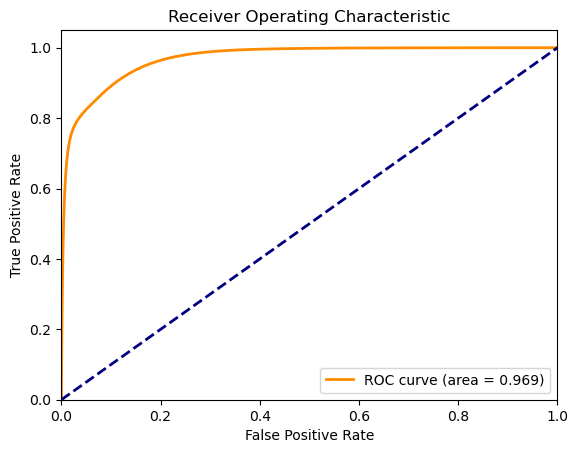

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def model_outputs(features, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        inputs = torch.tensor(features, dtype=torch.float32).to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
    return outputs

# Calculate model outputs
probabilities = model_outputs(filtered_inputs, model)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(filtered_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

/tmp/ipykernel_912035/52354147.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


Prediction scores for displaced tracks (t5_sim_vxy > 0.1):
Mean score: 0.9042
Median score: 0.9864


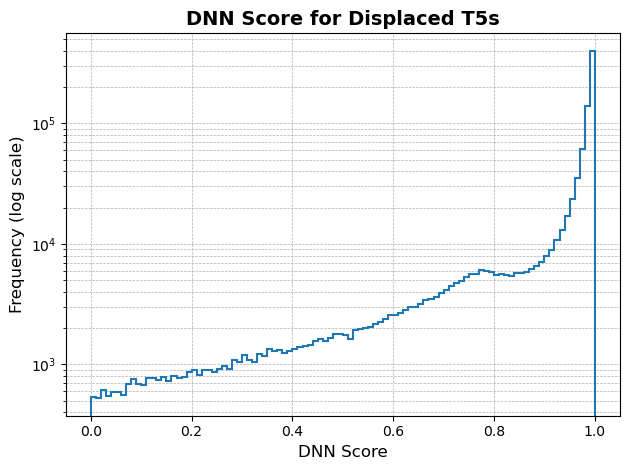

In [10]:
# Get model predictions
probabilities = model_outputs(filtered_inputs, model)

# Get displaced track mask
displaced_mask = np.concatenate(branches['t5_sim_vxy'])[downsample_mask][~nan_mask] > 0.1

# Calculate statistics for displaced tracks
displaced_predictions = probabilities[displaced_mask]
mean_score = np.mean(displaced_predictions)
median_score = np.median(displaced_predictions)

print(f"Prediction scores for displaced tracks (t5_sim_vxy > 0.1):")
print(f"Mean score: {mean_score:.4f}")
print(f"Median score: {median_score:.4f}")

plt.hist(displaced_predictions, bins=100, histtype='step', linewidth=1.5)  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score for Displaced T5s", fontsize=14, weight='bold')

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [11]:
def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()

    # Print weights
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()

def print_model_weights_biases(model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Iterate through all named modules in the model
    for name, module in model.named_modules():
        # Check if the module is a linear layer
        if isinstance(module, nn.Linear):
            # Get weights and biases
            weights = module.weight.data.cpu().numpy()
            biases = module.bias.data.cpu().numpy()

            # Print formatted weights and biases
            print_formatted_weights_biases(weights, biases, name.replace('.', '_'))

print_model_weights_biases(model)


ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_layer1[32] = {
0.4670540f, 2.0943611f, -0.1524337f, 2.0635159f, 0.0040177f, -0.0821457f, 0.0736396f, 5.2032447f, 0.0361609f, 0.1727931f, -1.7405432f, 0.3305918f, 0.0778312f, 2.1739702f, 0.2935444f, 0.7136542f, 1.8132486f, -0.0738565f, -1.9930780f, 0.0341746f, 0.7133607f, 0.1223772f, 2.6880448f, -0.2306636f, -2.4186764f, 2.4530363f, 0.0683014f, -1.1782986f, -0.3831011f, 0.0461447f, -1.3260516f, -0.1061450f };

ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_layer1[23][32] = {
{ -0.1686163f, -0.5560054f, -1.0804908f, 3.1910965f, -0.4027714f, -0.1838518f, -0.9310515f, 0.1689579f, -0.2491365f, 0.1303063f, 3.6639256f, 0.9541333f, 0.0648588f, 2.9912217f, 0.4319862f, -0.0755429f, 0.2163214f, -0.1414032f, 3.1782019f, -0.2590139f, 3.5281944f, 1.0792181f, 1.7679592f, 0.1262088f, 0.2884231f, 3.3543477f, 0.3155387f, 1.5153238f, -0.1788272f, 0.1961868f, -1.0027627f, -0.1625007f },
{ -0.0302904f, 0.0186884f, 0.0143479f, -0.0183586f, 0.0471184f, 0.0376305f,

In [12]:
# Ensure input_features_tensor is moved to the appropriate device
input_features_tensor = input_features_tensor.to(device)

# Make predictions
with torch.no_grad():
    model.eval()
    outputs = model(input_features_tensor)
    predictions = outputs.squeeze().cpu().numpy()

full_tracks = (np.concatenate(branches['t5_isFake']) == 0) * (np.concatenate(branches['t5_pMatched']) > 0.95)

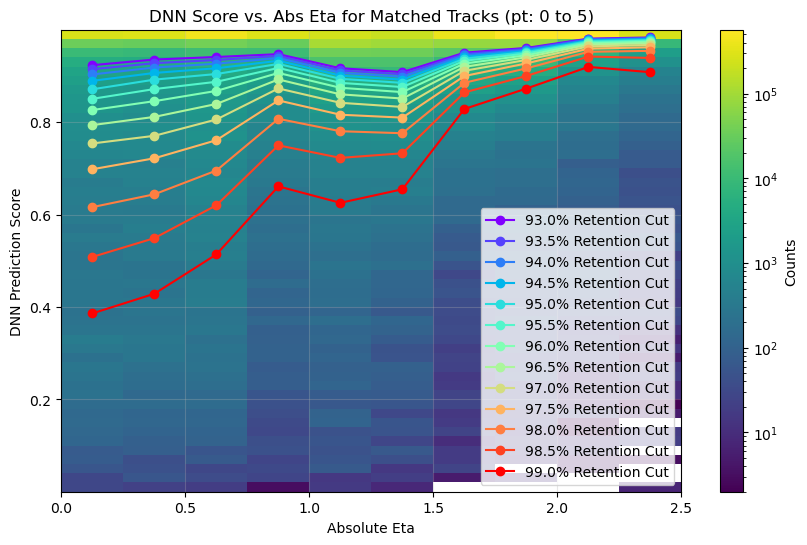


pt: 0 to 5
93.0% Retention Cut: {0.9231, 0.9354, 0.9409, 0.947, 0.9165, 0.9082, 0.9502, 0.9605, 0.9806, 0.9831} Mean: 0.9446
93.5% Retention Cut: {0.9144, 0.9275, 0.9344, 0.9433, 0.9117, 0.9035, 0.9476, 0.9585, 0.9795, 0.9821} Mean: 0.9403
94.0% Retention Cut: {0.9031, 0.918, 0.9264, 0.9385, 0.9065, 0.898, 0.9448, 0.9565, 0.9782, 0.9809} Mean: 0.9351
94.5% Retention Cut: {0.8893, 0.9064, 0.9165, 0.9327, 0.9004, 0.8919, 0.9412, 0.9541, 0.9768, 0.9795} Mean: 0.9289
95.0% Retention Cut: {0.871, 0.8919, 0.904, 0.9259, 0.8936, 0.8849, 0.9373, 0.9515, 0.9752, 0.9779} Mean: 0.9213
95.5% Retention Cut: {0.8503, 0.8715, 0.8872, 0.9172, 0.8849, 0.8759, 0.9326, 0.9485, 0.973, 0.9761} Mean: 0.9117
96.0% Retention Cut: {0.8261, 0.8453, 0.8675, 0.9063, 0.8742, 0.8649, 0.9267, 0.9446, 0.9706, 0.9738} Mean: 0.9
96.5% Retention Cut: {0.7935, 0.8113, 0.8392, 0.8923, 0.86, 0.851, 0.9195, 0.9403, 0.9676, 0.9707} Mean: 0.8845
97.0% Retention Cut: {0.7538, 0.7703, 0.8057, 0.8728, 0.8417, 0.8328, 0.9109, 0.

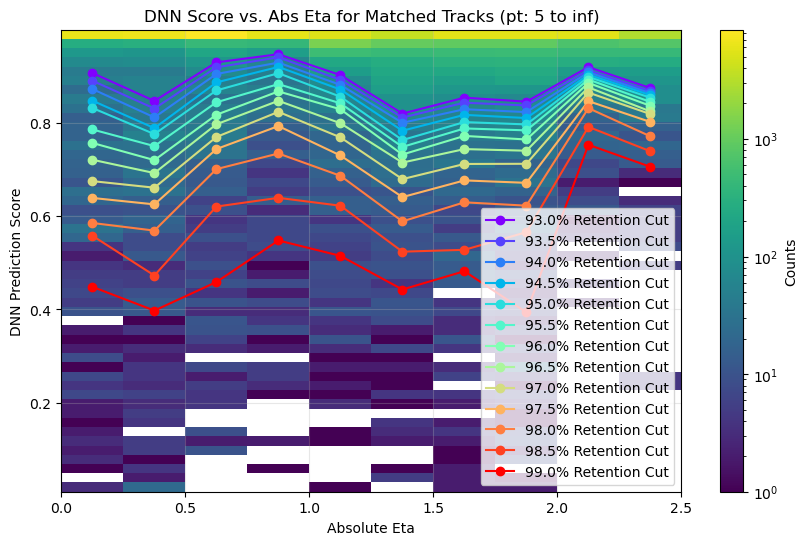


pt: 5 to inf
93.0% Retention Cut: {0.9071, 0.8472, 0.9299, 0.9474, 0.9027, 0.8201, 0.8543, 0.8456, 0.9198, 0.8749} Mean: 0.8849
93.5% Retention Cut: {0.8906, 0.8309, 0.9193, 0.9408, 0.8926, 0.8116, 0.8435, 0.8376, 0.9132, 0.8684} Mean: 0.8748
94.0% Retention Cut: {0.8727, 0.8119, 0.905, 0.9295, 0.8817, 0.8004, 0.8295, 0.8233, 0.9086, 0.864} Mean: 0.8627
94.5% Retention Cut: {0.8478, 0.7889, 0.887, 0.9202, 0.8717, 0.7833, 0.8174, 0.8106, 0.9035, 0.8598} Mean: 0.849
95.0% Retention Cut: {0.8321, 0.7761, 0.8698, 0.9067, 0.8563, 0.7633, 0.8019, 0.7968, 0.8988, 0.8542} Mean: 0.8356
95.5% Retention Cut: {0.786, 0.7503, 0.8443, 0.8834, 0.8421, 0.7486, 0.7882, 0.7841, 0.8931, 0.8451} Mean: 0.8165
96.0% Retention Cut: {0.7571, 0.7202, 0.8176, 0.8677, 0.8294, 0.7323, 0.7722, 0.7646, 0.8859, 0.8367} Mean: 0.7984
96.5% Retention Cut: {0.7211, 0.6925, 0.7972, 0.8475, 0.7994, 0.715, 0.7439, 0.7404, 0.8763, 0.8248} Mean: 0.7758
97.0% Retention Cut: {0.6752, 0.6611, 0.7699, 0.8238, 0.7691, 0.6795, 0.

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

def plot_for_pt_bin(pt_min, pt_max, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, downsample_mask, branches):
    """
    Calculate and plot cut values for specified percentiles in a given pt bin
    
    Parameters:
    -----------
    pt_min : float
        Minimum pt value for the bin
    pt_max : float
        Maximum pt value for the bin
    percentiles : list
        List of percentiles to calculate (e.g., [92.5, 96.7, 99])
    eta_bin_edges : array
        Edges of the eta bins
    eta_list : list
        List of eta values
    predictions : array
        Array of DNN predictions
    full_tracks : array
        Boolean array for track selection
    downsample_mask : array
        Boolean array from downsampling
    branches : dict
        Dictionary containing branch data
    """
    # First apply the downsample mask to all relevant arrays
    pt_values = np.concatenate(branches['t5_pt'])[downsample_mask]
    eta_values = eta_list[0][downsample_mask]
    full_tracks_masked = full_tracks[downsample_mask]
    
    # Then create the pt bin mask
    pt_mask = (pt_values > pt_min) & (pt_values <= pt_max)
    
    # Combine with full_tracks mask
    final_mask = full_tracks_masked & pt_mask
    
    # Apply final mask to get filtered data
    abs_eta = eta_values[final_mask]
    predictions_filtered = predictions[final_mask]
    
    # Dictionary to store cut values for different percentiles
    cut_values = {p: [] for p in percentiles}

    # Loop through each eta bin
    for i in range(len(eta_bin_edges) - 1):
        # Get indices of tracks within the current eta bin
        bin_indices = (abs_eta >= eta_bin_edges[i]) & (abs_eta < eta_bin_edges[i + 1])
        
        # Get the corresponding DNN prediction scores
        bin_predictions = predictions_filtered[bin_indices]
        
        if len(bin_predictions) > 0:  # Only calculate if we have data in this bin
            # Calculate the percentile cut values for the current bin
            for percentile in percentiles:
                cut_value = np.percentile(bin_predictions, 100 - percentile)  # Convert retention to percentile
                cut_values[percentile].append(cut_value)
        else:
            # If no data in bin, append NaN or some default value
            for percentile in percentiles:
                cut_values[percentile].append(np.nan)

    # Plot 2D histogram
    plt.figure(figsize=(10, 6))
    plt.hist2d(abs_eta, predictions_filtered, bins=[eta_bin_edges, 50], norm=LogNorm())
    plt.colorbar(label='Counts')
    plt.xlabel("Absolute Eta")
    plt.ylabel("DNN Prediction Score")
    plt.title(f"DNN Score vs. Abs Eta for Matched Tracks (pt: {pt_min} to {pt_max})")

    # Plot the cut values with different colors
    cut_x = eta_bin_edges[:-1] + (eta_bin_edges[1] - eta_bin_edges[0]) / 2  # Mid-points of the bins
    colors = plt.cm.rainbow(np.linspace(0, 1, len(percentiles)))  # Generate distinct colors
    
    for percentile, color in zip(percentiles, colors):
        plt.plot(cut_x, cut_values[percentile], '-', color=color, marker='o', 
                label=f'{percentile}% Retention Cut')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print the cut values
    print(f"\npt: {pt_min} to {pt_max}")
    for percentile in percentiles:
        values = cut_values[percentile]
        print(f"{percentile}% Retention Cut:", 
              '{' + ', '.join(str(x) for x in np.round(values, 4)) + '}',
              "Mean:", np.round(np.mean([x for x in values if not np.isnan(x)]), 4))

def analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, downsample_mask, branches):
    """
    Analyze and plot for multiple pt bins and percentiles
    
    Parameters:
    -----------
    pt_bins : list
        List of pt bin edges
    percentiles : list
        List of percentiles to calculate
    Other parameters same as plot_for_pt_bin function
    """
    for i in range(len(pt_bins) - 1):
        plot_for_pt_bin(pt_bins[i], pt_bins[i + 1], percentiles, eta_bin_edges, 
                       eta_list, predictions, full_tracks, downsample_mask, branches)

# Example call:
percentiles = np.arange(93, 99.5, 0.5)
pt_bins = [0, 5, np.inf]
eta_bin_edges = np.arange(0, 2.75, 0.25)
analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, 
                full_tracks, downsample_mask, branches)